In [24]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.4


## REINFORCE-Karpathy Downsample

Original version - downsample by 2 --> 80x80

(210, 160, 3)


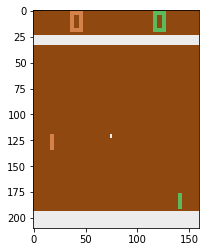

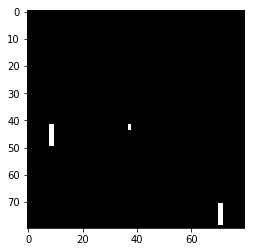

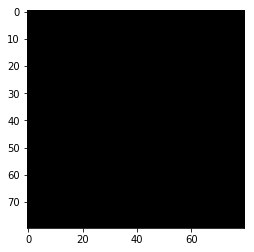

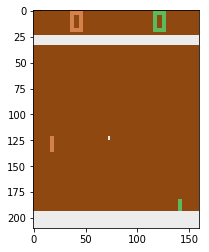

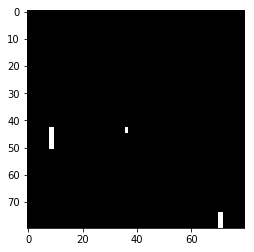

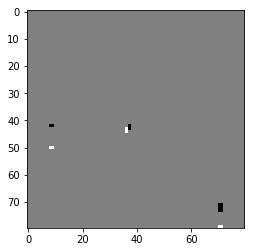

In [42]:
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

env = gym.make("Pong-v0")
state = env.reset()
print (state.shape)

# Play 20 steps
for i in range(20):
    action = random.randint(2,3)
    state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

prev_x = None

# display original image
plt.figure(figsize=(4,4))
plt.imshow(state) 
plt.show()  

cur_x = prepro80(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
prev_x = cur_x

plt.figure(figsize=(4,4))
plt.imshow(cur_x.reshape(80,80)) 
plt.show()  # display it

plt.figure(figsize=(4,4))
plt.imshow(state.reshape(80,80)) 
plt.show()  # display it

# play 1 more step
state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

# display original image
plt.figure(figsize=(4,4))
plt.imshow(state) 
plt.show()  

cur_x = prepro80(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
prev_x = cur_x

plt.figure(figsize=(4,4))
plt.imshow(cur_x.reshape(80,80)) 
plt.show()  # display it

plt.figure(figsize=(4,4))
plt.imshow(state.reshape(80,80)) 
plt.show()  # display it

In [44]:
for i in range(80):
    print(state.reshape(80,80)[i,:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  

In [40]:
env.close()

## Issue with Downsample by 4

Downsample by 4 --> 80x80. 

Sometimes, the puck is sampled out and no longer visible in the delta image.

(210, 160, 3)


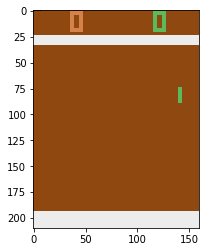

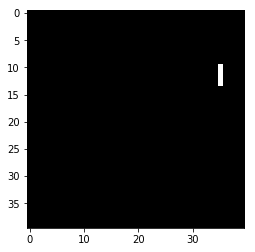

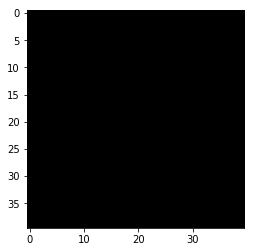

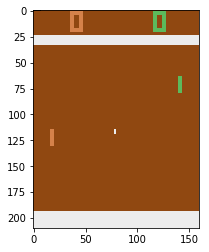

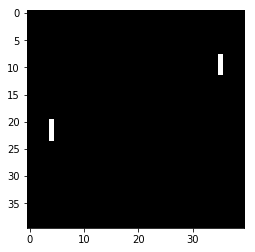

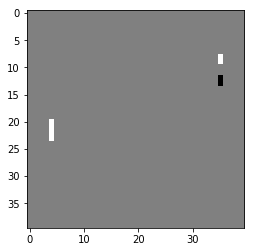

In [22]:
def prepro40(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

env = gym.make("Pong-v0")
state = env.reset()
print (state.shape)

# Play 20 steps
for i in range(20):
    action = random.randint(2,3)
    state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

prev_x = None

# display original image
plt.figure()
plt.imshow(state) 
plt.show()  

cur_x = prepro40(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
prev_x = cur_x

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

plt.figure()
plt.imshow(state.reshape(40,40)) 
plt.show()  # display it

# play 1 more step
state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

# display original image
plt.figure()
plt.imshow(state) 
plt.show() 

cur_x = prepro40(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
prev_x = cur_x

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

plt.figure()
plt.imshow(state.reshape(40,40)) 
plt.show()  # display it

## REINFORCE-V2 

This issue with downsampling results in the model not learning. The weight images are noisy and do not show clear trajectory paths as those of REINFORCE-Karpathy.

(200, 1600)


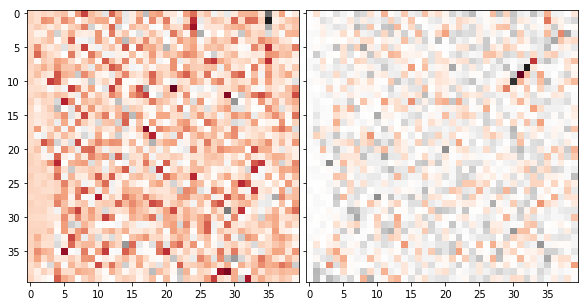

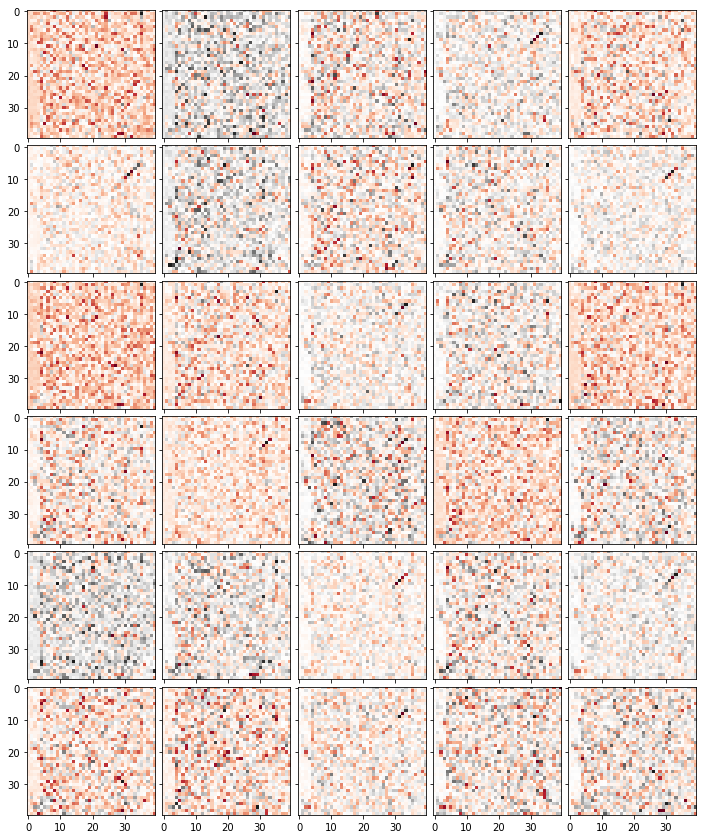

In [25]:
# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

    
model = Policy()
file_name='./results/reinforce/reinforce-v2/pong_ep=28000model.pt'
model.load_state_dict(torch.load(file_name))

from mpl_toolkits.axes_grid1 import ImageGrid

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()
    
print (W['affine1.weight'].shape)



# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (10., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][0,:].reshape(40,40)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][9,:].reshape(40,40)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(30):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(40,40)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

(210, 160, 3)


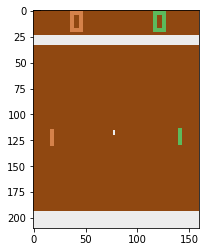

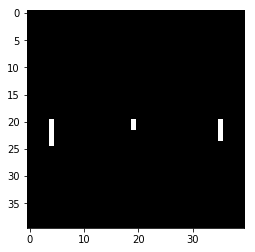

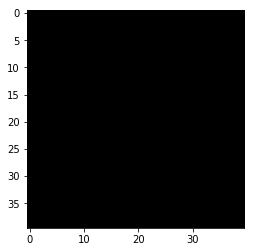

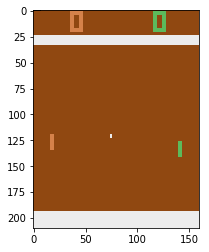

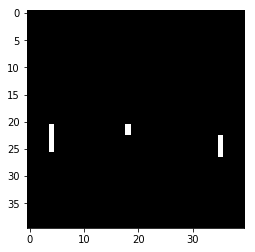

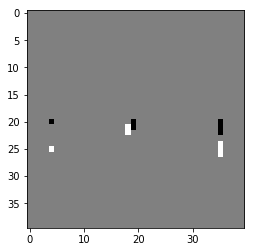

In [54]:
def process_frame40(I):
    I = I[34:34 + 160, :160, 0]
    # Resize by half, then down to 40x40 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    I = cv2.resize(I, (80, 80))
    I = cv2.resize(I, (40, 40))
    
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1

    I = np.reshape(I, [-1]).astype(np.float32)
    return I

env = gym.make("Pong-v0")
state = env.reset()
print (state.shape)

# Play 20 steps
for i in range(20):
    action = random.randint(2,3)
    state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

prev_x = None


# display original image
plt.figure(figsize=(4,4))
plt.imshow(state) 
plt.show()  

cur_x = process_frame40(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
prev_x = cur_x

plt.figure(figsize=(4,4))
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

plt.figure(figsize=(4,4))
plt.imshow(state.reshape(40,40)) 
plt.show()  # display it

# play 1 more step
state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

# display original image
plt.figure(figsize=(4,4))
plt.imshow(state) 
plt.show()  

cur_x = process_frame40(state)
state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
prev_x = cur_x

plt.figure(figsize=(4,4))
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

plt.figure(figsize=(4,4))
plt.imshow(state.reshape(40,40)) 
plt.show()  # display it

In [51]:
for i in range(40):
    print(state.reshape(40,40)[i,:])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 0.  0.  0.  0.